# Keras Tuner: Reuters Dataset

## Conjunto de datos

Este es un conjunto de datos de 11.228 noticias de Reuters, etiquetadas en 46 temas.

Esto fue originalmente generado por el análisis y preprocesamiento del clásico conjunto de datos de Reuters-21578, pero el código de preprocesamiento ya no está empaquetado con Keras. 

Cada noticia está codificado como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por la frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como: "considerar sólo las 10.000 palabras más comunes, pero eliminar las 20 palabras más comunes".

## 1. Cargando el conjunto de datos

In [75]:
import IPython

# <-- Machine learning -->
from sklearn.model_selection import train_test_split

# <-- Deep learning -->
import keras
from keras.datasets import reuters
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import optimizers
import keras_tuner as kt

# <-- Analytics -->
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

## Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

In [77]:
def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [78]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [79]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

Valores originales:	 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [80]:
# Transformamos las etiquetas de salida en vectores
Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

## División del conjunto de datos 

In [81]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [82]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


## Construcción de la red neuronal artificial

### Función para la realización del tuning

In [83]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)
    
    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(10000,)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        
    # Output layer
    model.add(layers.Dense(46, activation='softmax'))
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [84]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hp_dir',
    project_name='ruters_dataset'
)

Reloading Tuner from hp_dir/ruters_dataset/tuner0.json


In [85]:
# Creamos una función de callback que limpie el output
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [86]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[ClearTrainingOutput()]
)

In [87]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))

Units: 72
Layers: 2


In [88]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    validation_data = (X_val, Y_val)
)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5376 - loss: 2.0850 - val_accuracy: 0.7435 - val_loss: 1.0292
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8555 - loss: 0.6228 - val_accuracy: 0.7916 - val_loss: 0.9255
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9379 - loss: 0.2637 - val_accuracy: 0.7854 - val_loss: 0.9997
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9524 - loss: 0.1869 - val_accuracy: 0.7916 - val_loss: 1.0211
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9554 - loss: 0.1517 - val_accuracy: 0.7943 - val_loss: 1.0455
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9580 - loss: 0.1305 - val_accuracy: 0.7872 - val_loss: 1.0990
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9556 - loss: 0.1277 - val_accuracy: 0.8059 - val_loss: 1.1086
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9583 - loss: 0.1036 - val_accuracy: 0.

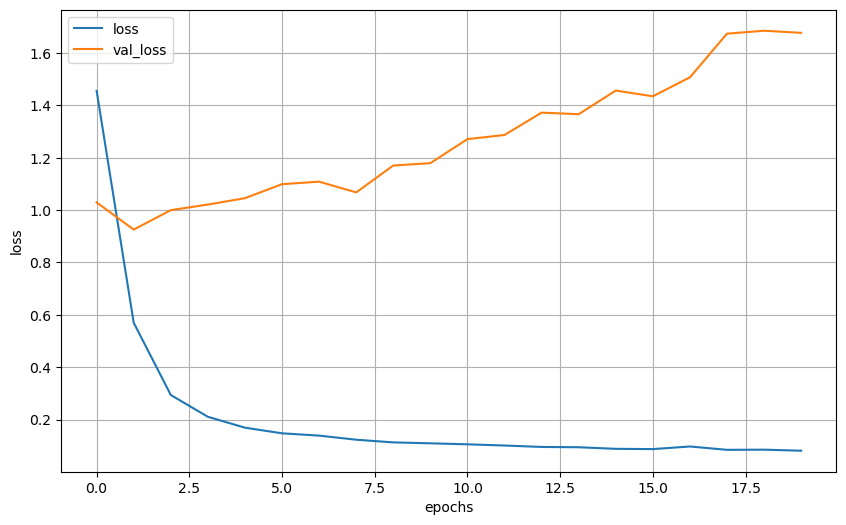

In [89]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

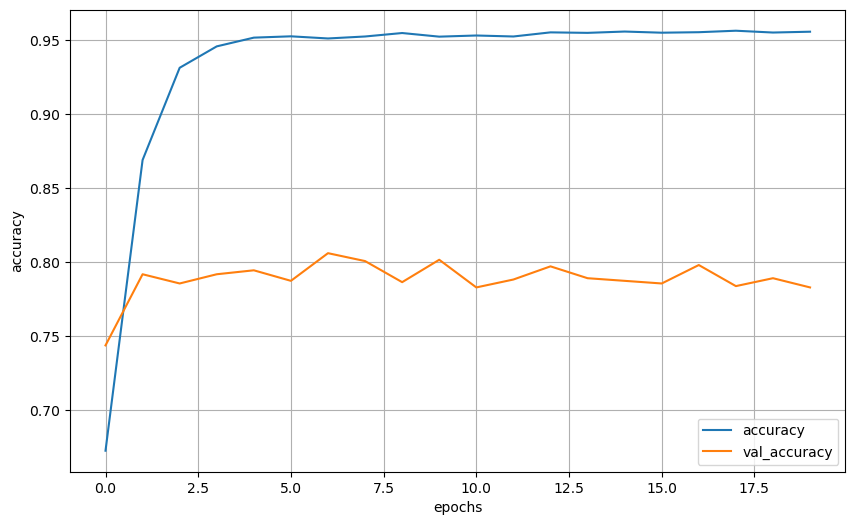

In [90]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [91]:
model.evaluate(X_test, Y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7777 - loss: 1.4454 


[1.5721534490585327, 0.7845057845115662]

In [92]:
model.predict(X_test).round(0)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)